In [1]:
pip install matplotlib numpy scipy sympy control --user

Note: you may need to restart the kernel to use updated packages.


# Modelagem de sistemas dinâmicos com python:
Esse notebook complementar visa introduzir (brevemente) os alunos da disciplina de CSD à biblioteca ***control*** (ctl) para python. São abordados aqui:

***i)*** Como realizar uma transformada de Laplace simbólica (biblioteca ***sympy***);

***ii)*** Como construir uma função de transferência para uma planta genérica no domínio $s$ (biblioteca ***control***);

***iii)*** Como construir um controlador por combinação linear de $K_p$, $K_i$, e $K_d$ (biblioteca ***control***);

***iv)*** Como plotar o lugar das raízes para um sistema Planta-Controlador em MF (biblioteca ***control***);

***v)*** Como determinar a resposta $Y(t)$ do sistema em MF à um sinal de entrada $u(t)$ qualquer (biblioteca ***control***).

Mais informações sobre as bibliotecas podem ser encontradas em:

https://python-control.readthedocs.io/en/0.9.0/intro.html

https://dynamics-and-control.readthedocs.io/en/latest/0_Getting_Started/Notebook%20introduction.html

Autor: Caio Dias Fernandes, Matrícula: 16204719

In [2]:
import numpy as np
import sympy as sym #biblioteca para operações simbólicas
import control as ctl #toolbox de controle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# i) Transformada de Laplace (TL)

Um dos primeiros passos na modelagem de sistemas dinâmicos é transformar uma função $f(t)$ (que descreva a planta de interesse no do tempo) para o domínio $s$, resultando em $F(s)$. A biblioteca ***sympy*** permite realizar a TL de modo simbólico, facilitando a visualização de $F(s)$ em sua forma característica.

A TL é implementada pela função sym.laplace_transform(f, t, s), que calcula a integral imprópria $\int_0^{\infty} \left[f(t)e^{-st}\right]ds$ (definição da TL), utilizando as variáveis simbólicas $t$ e $s$. No código abaixo o argumento adicional noconds=True também é passado à essa função, para evitar printar as condições de convergência da integral imprópria.

Esse código simples nos permite obter uma expressão para $F(s)$ que pode ser facilmente implementada posteriormente na biblioteca control. Observe a sequência de operações simbólicas listadas após a TL.

Como exemplo, tomou-se aqui uma $f(t)$ qualquer:

$$f(t) = 0.2(t-5) e^{-5t} \mathrm{cos}(2t) \rightarrow F(s) = \frac{s^3 + 15.2s^2 + 81s + 149.2}{s^4 + 20s^3 + 158s^2 + 580s + 841} $$

Verifique também algumas $f(t)$ com $F(s)$ conhecidas; como a função degrau unitário (f = 1), rampa (f = t), e exponencial (f = sym.exp(-t)).

In [3]:
t, s = sym.symbols('t, s') # Determina que t e s são variáveis simbólicas

# Função característica no domínio do tempo [f(t)]:
f = 0.2*(t+5) * sym.exp(-5*t) * sym.cos(2*t)

# Transformada de Laplace [F(s) = TL(f(t))]:
F = sym.laplace_transform(f, t, s, noconds=True)
F = sym.expand(F) # expande as frações de F(s) em potências únicas de s
F = sym.collect(F, s) # agrupa os coeficientes das potências de s
F = sym.cancel(F) # reduz a expressão para a forma canônica F(s) = numerador / denominador

print("f(t) = {}".format(f))
print("F(s) = {}".format(F))

f(t) = (0.2*t + 1.0)*exp(-5*t)*cos(2*t)
F(s) = (1.0*s**3 + 15.2*s**2 + 81.0*s + 149.2)/(1.0*s**4 + 20.0*s**3 + 158.0*s**2 + 580.0*s + 841.0)


# ii) Função de Transferência (TF)

Para definir uma TF na biblioteca ***control*** basta conhecer as expressões para o numerador ($p$) e denominador ($q$) de $F(s) = \frac{p}{q}$, algo que pode ser obtido pelas tabelas de transformada de laplace ou seguindo o procedimento do item i). A classe ctl.tf define a TF atraveś de dois vetores; o primeiro correspondendo às potências decrescentes de $s$ do polinômio $p$, e o segundo às potências decrescentes de $s$ do polinômio $q$.

In [4]:
# Definição da TF da planta [H(s)]
# p = [2, 0.8, -7.92]
# q = [2, 1.6, 16.48, 6.464, 32.6432]
p = [1, 15.2, 81, 149.2]
q = [1, 20, 158, 580, 841]
H = ctl.tf(p , q) 
print(r"TF da Planta: {}".format(H))

TF da Planta: 
   s^3 + 15.2 s^2 + 81 s + 149.2
------------------------------------
s^4 + 20 s^3 + 158 s^2 + 580 s + 841



# iii) Controlador PID por combinação linear

Ainda utilizando a classe ***tf*** da biblioteca ***control*** é simples definir um controlador para a planta $H(s)$ lembrando que um controlador qualquer pode ser definido por:

$$ G(s) = K_p + K_i \frac{1}{s} + K_d s $$

onde $K_p$, $K_i$, $K_d$ correspondem aos ganhos das ações de controle proporcional, integral, e derivativa, respectivamente.

Repare que os argumentos passados à função ctl.tf() seguem o mesmo padrão de vetores dos coeficientes de polinômios de $s$. Note também o uso da função ctl.parallel(), que realiza uma operação de álgebra de blocos com cada parcela de $G(s)$. A biblioteca control também permite outras operações de algebra de blocos.

Verifique outros valores para $K_p$, $K_i$, e $K_d$ e observe o impacto disso no plot final do item (v).

In [5]:
# Combinação linear das ações de controle
Kp = 1 # Ação proporcional 
Ki = 1.5 # Ação integral
Kd = 0.8 # Ação derivativa
Gp = ctl.tf([Kp], [1])
Gi = ctl.tf([Ki], [1,0])
Gd = ctl.tf([Kd,0], [1])
G = ctl.parallel(Gp, Gi, Gd) # Combinação linear das ações de controle
print(r"TF do controlador:  {}".format(G))

TF do controlador:  
0.8 s^2 + s + 1.5
-----------------
        s



# iv) Lugar das Raízes

A biblioteca ***control*** também torna simples plotar o root-locus de um sistema dinâmico qualquer. 

Neste exemplo, incialmente definimos uma TF final ($G_{mf}(s)$) para o sistema Planta ($H(s)$) e Controlador ($G(s)$) realimentados (em malha fechada). Para tanto utilizam-se as funções ctl.series() (visto que $H(s)$ e $G(s)$ estão em série) e ctl.feedback() (realimentação), ambas operações comuns da álgebra de blocos.

Uma vez definido $G_{mf}(s)$ o lugar das raízes pode ser plotado com a função ctl.rlocus(), onde os polos são representados por cruzes (X) e os zeros por círculos (O), pelo preset default da função. 

Também é possível obeter a posição precisa dos zeros com as funçoes ctl.poles() e ctl.zeros(). Informações adicionais como $\omega_n$ e $\zeta$ podem ser obtidas com a função ctl.damp() (o argumento adicional doprint=True printa o output no console).

TF sistema de feedback: 
0.8 s^5 + 13.16 s^4 + 81.5 s^3 + 223.2 s^2 + 270.7 s + 223.8
------------------------------------------------------------
1.8 s^5 + 33.16 s^4 + 239.5 s^3 + 803.2 s^2 + 1112 s + 223.8

Polos: [-5.18+2.01j -5.18-2.01j -3.91+1.21j -3.91-1.21j -0.24+0.j  ]
Zeros: [-5.2 +2.01j -5.2 -2.01j -4.8 +0.j   -0.63+1.22j -0.63-1.22j]


_____Eigenvalue______ Damping___ Frequency_
    -5.181    +2.013j     0.9321      5.558
    -5.181    -2.013j     0.9321      5.558
     -3.91    +1.215j      0.955      4.094
     -3.91    -1.215j      0.955      4.094
   -0.2401                     1     0.2401


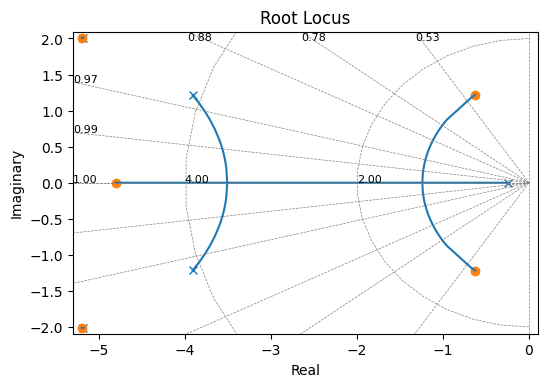

In [6]:
# Álgebra de blocos
P = ctl.series(H, G) # Série
G_mf = ctl.feedback(P) # Loop de feedback / relaimentação(negativo por default)
print(r"TF sistema de feedback: {}".format(G_mf))

# Localização dos polos e zeros
p = ctl.pole(G_mf)
z = ctl.zero(G_mf)
polos = np.round(p, decimals=2)
zeros = np.round(z, decimals=2)
print(r"Polos: {}".format(polos))
print(r"Zeros: {}".format(zeros))

# Informações adicionais (Autovalores, Frquências e amortecimentos associados)
print('\n')
sysInfo = ctl.damp(G_mf, doprint=True)

# Plot lugar das raízes
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100

ctl.rlocus(G_mf)
plt.show()

# v) Resposta à entrada qualquer

A biblioteca ***control*** implementa várias funções para simular modelos nos domínios $s$ e $t$. Neste exemplo simula-se a resposta ($Y(t)$) para o sistema planta-controlador em malha fechada ($G_{mf}(s)$) sujeito à um sinal de excitação qualquer ($U(t)$) tomado como:

$$ U(t) =     
    \begin{cases}
      e^{t/10} \mathrm{,} & t \leq \frac{t_f}{3}\\
      e^{t_f/30} \mathrm{,} & \frac{t_f}{3} \leq t < \frac{2t_f}{3}\\
      0  \mathrm{,} & \frac{2t_f}{3} \leq t \leq t_f
    \end{cases} $$
    
onde $U(t)$ também pode ser interpretado como um set-point variando no tempo para a planta. 

O código implementado a seguir define $U(t)$ como exposto, e calcula (numericmanete) cada parcela associada aos erros do controlador obtido por combinação linear; ou seja, determinam-se o erro, sua integral, e derivada.

Utiliza-se a função ctl.forced_response() que toma como inputs o vetor tempo de simulação ($t$), um sinal de entrada qualquer ($U(t)$), e o sistema de controle instanciado como um objeto da classe "input-output system" (io). Como a planta $G_{mf}$ é um objeto da classe "trasnfer function" (tf) (lembre-se da função ctl.tf), deve-se transformá-la para "io" através da função ctl.tf2io().

Sinta-se a vontade para alterar a função $U(t)$, bem como os paramêtros do controlador no item iii) e a prórpia planta à ser controlada nos itens i) e ii). Observe como as parcelas do erro evoluem ao longo do tempo, representando as diferentes ações de controle determinadas pelo controlador.

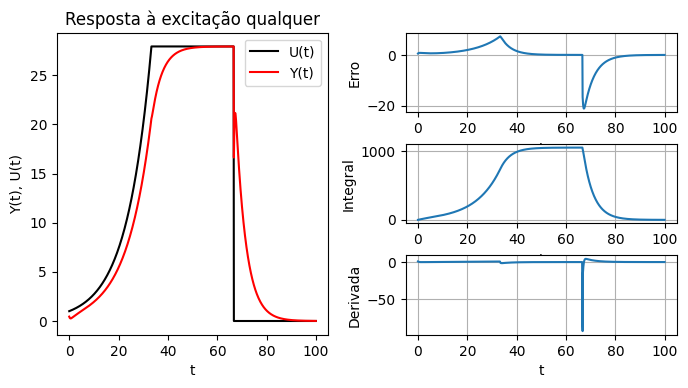

In [7]:
# tempo
t_i = 0 # t início da simulação
t_f = 100 # t final simulação
dt = 0.1 
t = np.arange(t_i,t_f,dt) # vetor tempo de simulação

# Definição do sinal de entrada U(t)
U = np.zeros(len(t))
for i in range(len(t)): # U(t) definida por partes
    if t[i] <= t_f/3:
        U[i] = np.exp(t[i]/10)
        aux = U[i]
    elif (t_f/3 < t[i] <= (2/3)*t_f):
        U[i] = aux
    elif t[i] > (2/5)*t_f:
        U[i] = 0

# Resposta do sistema à um sinal qualquer
IO_system = ctl.tf2io(G_mf)
[ty, Y] = ctl.forced_response(IO_system,t,U)

# Definição do erro
e = U - Y # Diferença entre resposta e set-point (sinal de entrada)
ei = np.cumsum(e) # Integral numérica de e (soma cumulativa)
ed = np.gradient(e, dt) # Derivada numérica de e (linear ponto a ponto)


## Plot
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100

fig = plt.figure()
gs = fig.add_gridspec(3,6, wspace=2, hspace=0.4)

ax0 = fig.add_subplot(gs[:,:3])
ax1 = fig.add_subplot(gs[0,3:])
ax2 = fig.add_subplot(gs[1,3:])
ax3 = fig.add_subplot(gs[2,3:])

ax0.plot(t, U, '-k', label='U(t)')
ax0.plot(t, Y, '-r', label='Y(t)')
ax0.set_xlabel('t')
ax0.set_ylabel('Y(t), U(t)')
ax0.set_title('Resposta à excitação qualquer')
ax0.legend()

ax1.plot(t, e)
ax1.set_xlabel('t')
ax1.set_ylabel('Erro')
ax1.grid()

ax2.plot(t, ei)
ax2.set_xlabel('t')
ax2.set_ylabel('Integral')
ax2.grid()

ax3.plot(t, ed)
ax3.set_xlabel('t')
ax3.set_ylabel('Derivada')
ax3.grid()

#fig.tight_layout()
plt.show()
